# Ranking Cambly tutors

### This notebook includes the following parts:
    1. merging and cleaning of different data sources (about tutors, chats, ratings),
    2. feature selection and processing including:
        - correction for student biases,
        - calculation of Bayesian averages,
        - variance of the tutor and connection ratings,
        - fraction of low ratings (<=3),
        - sentiment score of the written reviews,
        - count of certificates.
    3. training and testing a binary random forest classifier from sklearn, featuring:
        - stratified shuffled k-folds, with 35 % of the data used for testing,
        - class weighting, 
        - ROC for evaluation.
    4. evaluation of feature importances,
    5. predicting probabilities on an unlabeled dataset (high probability --> tutor is likely bad).

#### Note that for this analysis I worked with a sample of Cambly's data.

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.calibration import CalibratedClassifierCV 
from sklearn.ensemble import RandomForestClassifier as RF
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import Imputer
from sklearn import cross_validation
from scipy import interp

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['font.size'] = 15

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")

In [6]:
# %ls

# 

## Load data

In [7]:
# Load rating data
df_ratings = pd.read_csv('ratings.csv')
df_ratings_reduced = df_ratings[['tutor', 'chatId', 'tutorRating', 'reviewText', 'connectionRating']]
df_ratings_reduced = df_ratings_reduced.rename(columns={'chatId': 'chatID', 
                                                        'tutor':'tutorID_ratings', 
                                                        'tutorRating': 'tutorRating_ratings', 
                                                        'connectionRating': 'connectionRating_ratings'})

In [8]:
# Load tutor data
df_tutors = pd.read_csv('tutors-fulllist.csv')
df_tutors_reduced = df_tutors[['_id', 'tutor_certificates', 'username', 'pending']]
df_tutors_reduced.rename(columns={'_id': 'tutorID_tutors', 
                                  'username': 'username_tutors', 
                                  'tutor_certificates':'tutor_certificates_tutors' }, inplace=True)
df_tutors_reduced['tutorID_tutors'] = df_tutors_reduced['tutorID_tutors'].map(lambda x: str(x)[9:-1])

In [9]:
# Load chat data
df_chats = pd.read_csv('chats.csv', low_memory=False)
# Only paid chats included
df_chats_paid = df_chats[df_chats['paid'] == True]
# Exclude chats that don't have chat length information
df_chats_long = df_chats_paid[df_chats_paid.minutes.notnull()]
# Exclude chats shorter than 5 min
df_chats_long = df_chats_long[df_chats_long['minutes'] >=5.]
df_chats_reduced = df_chats_long[['_id', 'paid', 'minutes', 'student', 'tutor', 'startTime']]
df_chats_reduced['_id'] = df_chats_reduced['_id'].map(lambda x: str(x)[9:-1])
df_chats_reduced.rename(columns={'_id': 'chatID', 
                                 'paid': 'paid_chats', 
                                 'minutes':'minutes_chats', 
                                 'tutor': 'tutorID_chats', 
                                 'student': 'studentID_chats', 
                                 'startTime': 'startTime_chats'}, inplace=True)

In [10]:
# Drop duplicates if any
df_ratings_reduced = df_ratings_reduced.drop_duplicates('chatID')
df_chats_reduced = df_chats_reduced.drop_duplicates('startTime_chats')

## Merge into a single dataframe

In [11]:
chats_ratings_merged = pd.merge(left=df_chats_reduced,right=df_ratings_reduced, on='chatID')

In [12]:
chats_ratings_tutors_merged = pd.merge(left=chats_ratings_merged, right=df_tutors_reduced, left_on='tutorID_chats', right_on='tutorID_tutors')

In [13]:
combined_df = chats_ratings_tutors_merged[['chatID', 'paid_chats', 'pending', 'minutes_chats', 'studentID_chats',
                                                  'tutorID_chats', 'reviewText', 'username_tutors', 'tutor_certificates_tutors',
                                                  'connectionRating_ratings', 'tutorRating_ratings']]

In [14]:
# Replace nans or True/False labels if needed
# combined_df.replace(True, 1,inplace=True)
# combined_df.replace(False, 0,inplace=True)
combined_df=combined_df.replace({'tutor_certificates_tutors' : { np.nan: '', '[]' : ''}})
combined_df=combined_df.replace({'reviewText' : { np.nan: '', '[]' : ''}})

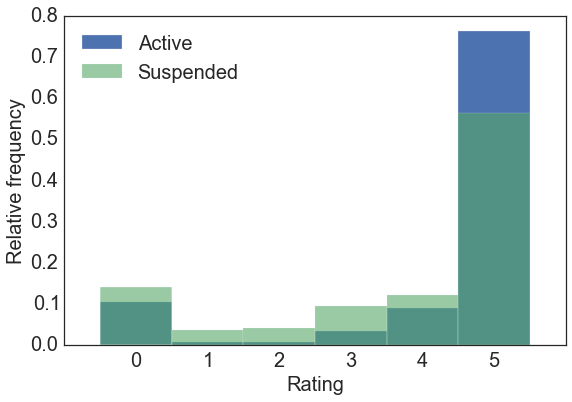

In [15]:
# Plot rating distributions for active and suspended tutors (uncorrected ratings)
f, ax = plt.subplots()
bins = np.linspace(0, 6, 7)
bincenters = 0.5*(bins[1:]+bins[:-1])
ax.hist(chats_ratings_tutors_merged['tutorRating_ratings'], normed = True, bins = bins, label = 'Active', align='left')
ax.hist(chats_ratings_tutors_merged['connectionRating_ratings'], normed = True, bins = bins, alpha = 0.6, label = 'Suspended', align='left')
ax.set_xlabel('Rating')
ax.set_ylabel('Relative frequency')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
ax.legend(fontsize = 20, loc = 'upper left')
ax.set_xticks(bins[:-1])

## Correct ratings for student biases

In [16]:
c =40.
m = 4.7 # tutor rating prior
m1 = 3.8 # connection rating prior

In [17]:
def student_correction(x, gloabal_avg):
    suma = np.sum(x[x>0.])
    how_many = len(x[x>0.])
    if suma != 0. and how_many != 0.:
        avg = float(suma)/float(how_many)
        return gloabal_avg - avg
    else:
        return np.nan

In [18]:
# Calculate correction
combined_df['delta_rating_tutor'] = combined_df.groupby('studentID_chats')['tutorRating_ratings'].transform(student_correction, m)
combined_df['delta_rating_conn'] = combined_df.groupby('studentID_chats')['connectionRating_ratings'].transform(student_correction, m1)

In [19]:
# Correct the grades (including the zero ratings)
# combined_df['corr_tutor_rating'] = combined_df['delta_rating_tutor'] + combined_df['tutorRating_ratings']
# combined_df['corr_conn_rating'] = combined_df['delta_rating_conn'] + combined_df['connectionRating_ratings']

In [20]:
# Function to correct non zero ratings for student biases
def addcorrrection(x, corr):
    if x > 0. :
        return x + corr
    else:
        return 0

In [21]:
# Correct the grades (but not the zero ratings)
combined_df['corr_tutor_rating'] = combined_df.apply(lambda row: addcorrrection(row['tutorRating_ratings'], row['delta_rating_tutor']), axis =1)
combined_df['corr_conn_rating'] = combined_df.apply(lambda row: addcorrrection(row['connectionRating_ratings'], row['delta_rating_conn']), axis =1)

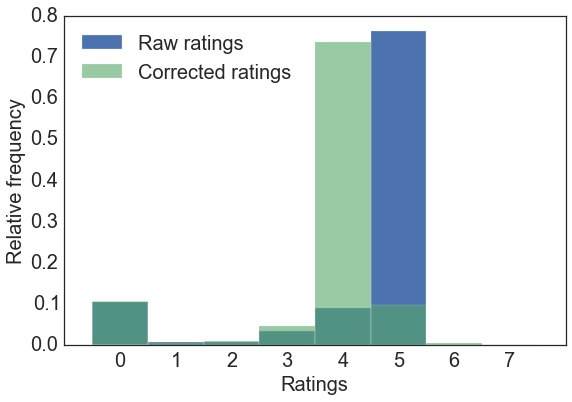

In [22]:
# Plot uncorrected and corrected tutor ratings
f, ax = plt.subplots()
bins = np.linspace(0, 8, 9)
bincenters = 0.5*(bins[1:]+bins[:-1])
ax.hist(combined_df['tutorRating_ratings'], normed = True, bins = bins, label = 'Raw ratings', align='left')
ax.hist(combined_df['corr_tutor_rating'], normed = True, bins = bins, alpha = 0.6, label = 'Corrected ratings', align='left')
ax.set_xlabel('Ratings')
ax.set_ylabel('Relative frequency')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
ax.legend(fontsize = 20, loc = 'upper left')
ax.set_xticks(bins[:-1])

## Group and aggregate features

In [23]:
# Group by tutor ID
grouped_df = combined_df.groupby('tutorID_chats')

In [24]:
# NLTK language tokenizer for text analysis (used for parsing certificate and written review data)
tokenizer = RegexpTokenizer(r'\w+')

In [25]:
# Function to extract number of certificates
def certificates(x):
    x = x.astype(str)
    tt = x.map(tokenizer.tokenize)
    max_nr = max(tt.map(len))
    return max_nr

In [26]:
# Function to get length (nr of words) of a column with strings
def get_length(x):
    x = x.astype(str)
    tt = x.map(tokenizer.tokenize)
    length =  sum(tt.map(len))
    return length

In [27]:
# Function to create sentiment dictionary
def sent_dict(ssf):
    scores = {}
    for line in ssf:
        term, score = line.split("\t")
        scores[term] = int(score)
    return scores

In [28]:
# Upload sentiment file

# AFINN is a list of English words rated for valence with an integer
# between minus five (negative) and plus five (positive). The words have
# been manually labeled by Finn Årup Nielsen in 2009-2011.
# Available at: http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=6010

sent_file = open('AFINN-111.txt')
dictionary = sent_dict(sent_file )

In [29]:
# Function to calculate the total sentiment score for each tutor (later divided by the number of chats per tutor)
def get_sent(x):
    sentiments = []
    x = tokenizer.tokenize(str(x))
    sent_score = float(0.0)
    for i in range(len(x)):
        for key,value in dictionary.iteritems():
            if key == x[i]:
                sentiments.append(key)
                sent_score += float(value)
    return sent_score

In [30]:
# Create aggregate features for each tutor
aggregated_df = grouped_df.agg({
                'pending' : lambda x: np.unique(x), # will output 1 if pending = True, and 0 if pending = False
                'username_tutors' : lambda x: np.unique(x), # to get the usernames
                'paid_chats' : lambda x: np.sum(x), # total number of paid chats (note: free chats are filtered out already)
                'minutes_chats' : lambda x: np.sum(x), # total number of minutes (note: chats shorter than 5 min are filtered out already)
                'studentID_chats' : lambda x: len(np.unique(x)), #  number of unique student IDs associated with the tutor
                'connectionRating_ratings' : lambda x: np.mean(x[x>0]), # average connection ratings (non-zero)
                'tutorRating_ratings' : lambda x: np.mean(x[x>0]), # average tutor ratings (non-zero)
                'tutor_certificates_tutors' :  lambda x: certificates(x), # number of certificates for each tutor
                'reviewText' : lambda x : get_sent(x) # total sentiment score reviews
                }).sort('pending', ascending = False)

In [31]:
# Give features more meaningful names
aggregated_df.rename(columns={'paid_chats': 'number_of_chats', 
                              'minutes_chats': 'total_number_of_minutes', 
                              'studentID_chats':'nr_of_unique_students', 
                              'connectionRating_ratings' : 'avg_connection_rating', 
                              'tutorRating_ratings' : 'avg_tutor_rating',
                               'tutor_certificates_tutors' : 'nr_of_certificates',
                             'reviewText' : 'sentiment'}, 
                     inplace=True)

In [32]:
# Create more features for each tutor
aggregated_df1 = grouped_df.agg({
                'minutes_chats' : lambda x: np.std(x), # standard deviation of chat length
                'connectionRating_ratings' : lambda x: np.std(x[x>0]), # standard deviation of connection ratings
                'tutorRating_ratings' : lambda x: np.std(x[x>0]), # standard deviation of tutor ratings
                })

In [33]:
# Give features more meaningful names
aggregated_df1.rename(columns={
                              'minutes_chats' : 'std_chat_length',
                              'connectionRating_ratings' : 'std_connection_rating', 
                              'tutorRating_ratings' : 'std_tutor_rating',}, 
                     inplace=True)

In [34]:
# Create more features for each tutor: number of low ratings (<=3)
aggregated_df2 = grouped_df.agg({
                'connectionRating_ratings' : lambda x: sum(x <= 3.), # number of low connection ratings
                'tutorRating_ratings' : lambda x: sum(x <= 3.), # number of low tutor ratings
                })

In [35]:
# Give features more meaningful names
aggregated_df2.rename(columns={
                              'connectionRating_ratings' : 'low_connection_ratings', 
                              'tutorRating_ratings' : 'low_tutor_ratings',}, 
                     inplace=True)

In [36]:
# Create more features for each tutor: number of nonzero ratings
aggregated_df3 = grouped_df.agg({
                'connectionRating_ratings' : lambda x: sum(x != 0), # number of low connection ratings
                'tutorRating_ratings' : lambda x: sum(x != 0.), # number of low tutor ratings
                })

In [37]:
# Give features more meaningful names
aggregated_df3.rename(columns={
                              'connectionRating_ratings' : 'nonzero_c_ratings', 
                              'tutorRating_ratings' : 'nonzero_t_ratings',}, 
                     inplace=True)

In [38]:
# Combine everything into a single dataframe
add_features = pd.merge(aggregated_df, aggregated_df1, left_index=True, right_index=True)
add_features = pd.merge(add_features, aggregated_df2, left_index=True, right_index=True)
add_features = pd.merge(add_features, aggregated_df3, left_index=True, right_index=True)

In [39]:
# Normalize some features by the total number of chats
add_features['avg_chat_length'] = add_features['total_number_of_minutes']/add_features['number_of_chats']
add_features['sentiment'] = add_features['sentiment']/add_features['number_of_chats']
add_features['fraction_of_low_t_ratings'] = add_features['low_tutor_ratings']/add_features['number_of_chats']
add_features['fraction_of_low_c_ratings'] = add_features['low_connection_ratings']/add_features['number_of_chats']
add_features['fraction_of_returning_students'] = (add_features['number_of_chats'] - add_features['nr_of_unique_students']) / add_features['number_of_chats']

##Bayesian average = (c x m + avg_rating x number_of_ratings)/(c + number_of_ratings)¶

c = 40.

Tutor rating prior: m = 4.7

Connection rating prior: m = 3.8

If the tutor is rated by a lot of people, its Bayesian average rating will be somewhat closer to a regular average. If, on the other hand, this is a relatively new tutor with few ratings, its Bayesian average rating will be very close to the average rating for all of the tutors.


In [40]:
# Calculate Bayesian rating
add_features['tutor_bayes_rating'] = (c*m + add_features['nonzero_t_ratings']*add_features['avg_tutor_rating'])/(c + add_features['nonzero_t_ratings'])
add_features['conn_bayes_rating'] = (c*m1 + add_features['nonzero_c_ratings']*add_features['avg_connection_rating'])/(c + add_features['nonzero_c_ratings'])

In [41]:
# Make a clean dataframe without irrelevant features
final_features = add_features[['username_tutors',
                               'number_of_chats',
                               'nr_of_certificates',
                               'sentiment',
                               'avg_chat_length',
                               'std_chat_length',
                               'fraction_of_low_t_ratings',
                               'fraction_of_low_c_ratings',
                               'fraction_of_returning_students',
                               'tutor_bayes_rating',
                               'conn_bayes_rating',
                               'std_tutor_rating',
                               'std_connection_rating',
                               'pending']]

In [42]:
# Drop rows with NaNs
final_features = final_features[['username_tutors',
                               'number_of_chats',
                               'nr_of_certificates',
                               'sentiment',
                               'avg_chat_length',
                               'std_chat_length',
                               'fraction_of_low_t_ratings',
                               'fraction_of_low_c_ratings',
                               'fraction_of_returning_students',
                               'tutor_bayes_rating',
                               'conn_bayes_rating',
                               'std_tutor_rating',
                               'std_connection_rating',
                               'pending']].dropna()

## Grab names of the approved tutors

In [43]:
# Tutors' in-house ratings from Dorothy's Excel sheet
ratings_cambly = pd.read_csv('inhouse-ratings.csv', index_col= None)
ratings_cambly = ratings_cambly[ratings_cambly['CamblyRating'] > 3.5] # Two tutors in the list are marked as deactivated/bad
approved_tutors = pd.DataFrame(ratings_cambly['Username'])

## Plot corresponding features of approved and suspended tutors

In [44]:
# Copy active tutors to a new dataframe
active = final_features[final_features['pending'] == 0]
# Filter active tutors by whether they are rated by Dorothy
active = pd.merge(active, approved_tutors, left_on='username_tutors', right_on ='Username')
active = active.drop('Username', 1)

In [45]:
# Copy deactivated tutors to a new dataframe
suspended = final_features[final_features['pending'] == 1]

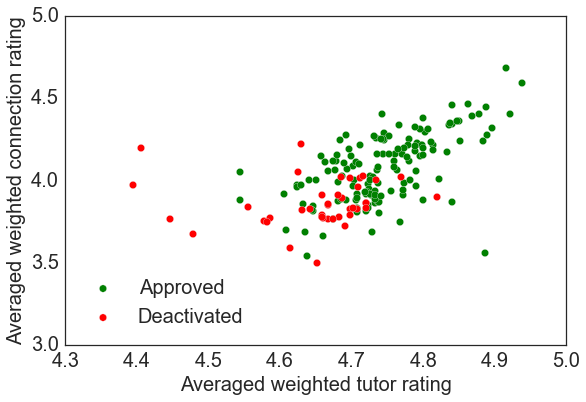

In [46]:
# Plot 
fig, ax = plt.subplots()
ax.scatter(active['tutor_bayes_rating'], active['conn_bayes_rating'], c= 'g', s = 53, label = 'Approved')
ax.scatter(suspended['tutor_bayes_rating'], suspended['conn_bayes_rating'], c= 'r', s = 53, label = 'Deactivated')
ax.set_xlim([4.3, 5.0])
ax.set_ylim([3., 5.0])
ax.set_xlabel('Averaged weighted tutor rating')
ax.set_ylabel('Averaged weighted connection rating')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
ax.legend(fontsize = 20, loc = 'lower left')

## Separate labeled and unlabeled tutors

In [47]:
# Labeled set: active tutors with in-house ratings + deactivated tutors
labeled_set = pd.concat([active, suspended])

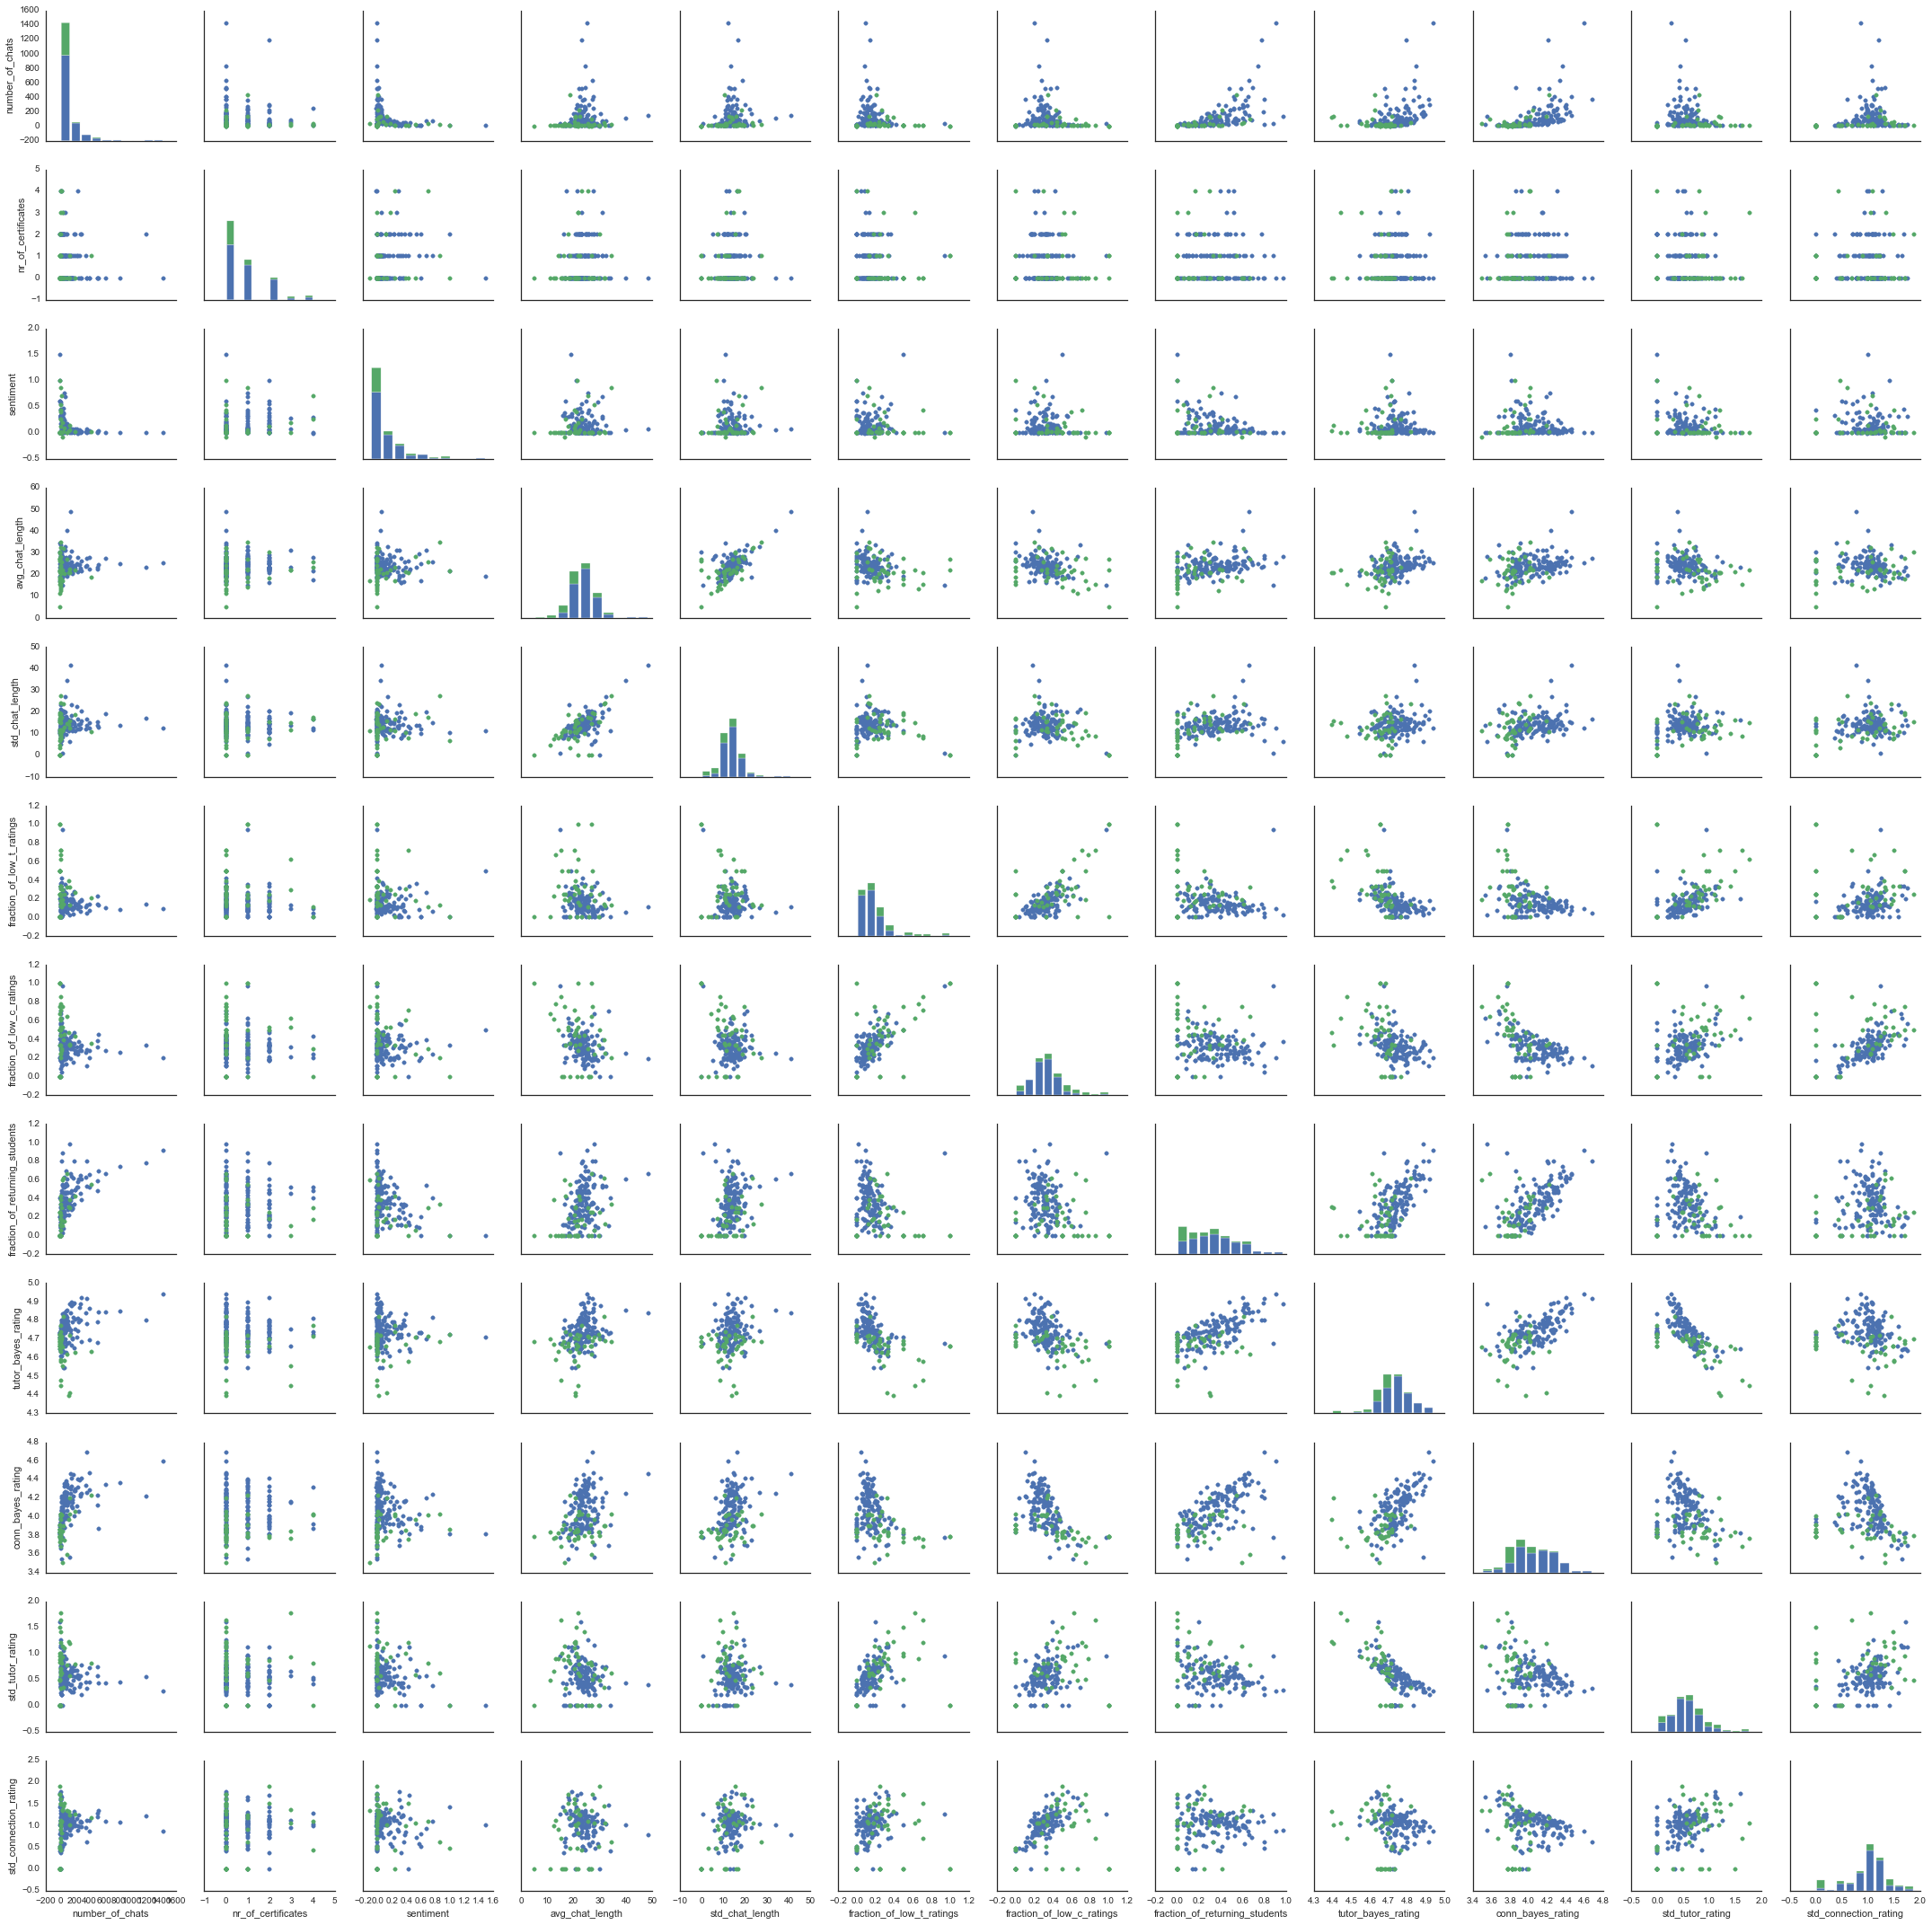

In [52]:
# Plot everything against everything, different colors for approved and suspended tutors
# comment out any of these variables to make the final plot more readable
g = sns.PairGrid(labeled_set, vars = ['number_of_chats', 
                               'nr_of_certificates',
                               'sentiment',
                               'avg_chat_length',
                               'std_chat_length',
                               'fraction_of_low_t_ratings',
                               'fraction_of_low_c_ratings',
                               'fraction_of_returning_students',
                               'tutor_bayes_rating',
                               'conn_bayes_rating',
                               'std_tutor_rating',
                               'std_connection_rating'
                                     ], hue = "pending")
g.map_offdiag(plt.scatter)
g.map_diag(plt.hist)

In [52]:
# Create a list of tutor names that have labels
list_of_labeled = list(set(labeled_set.username_tutors.tolist()))
# Unlabeled set: active tutors that don't have an in-house rating (and are not in list_of_labeled)
# Sorted alphabetically
unlabeled_set = final_features[~final_features.username_tutors.isin(list_of_labeled)].sort('username_tutors')

## Fit and test a model on the labeled set, predict on the unlabeled set

In [53]:
# Labels: replace 'pending' = True with 'pending' = 1, and 'pending' = False with 'pending' = 0
labels = labeled_set['pending']
y = np.where(labels == True,1,0)

In [54]:
# Select features from the labeled set
features = labeled_set[[
                       'number_of_chats',
                       'nr_of_certificates',
                       'sentiment',
                       'avg_chat_length',
                       'std_chat_length',
                       'fraction_of_low_t_ratings',
                       'fraction_of_low_c_ratings',
                       'fraction_of_returning_students',
                       'tutor_bayes_rating',
                       'conn_bayes_rating',
                       'std_tutor_rating',
                       'std_connection_rating',
    ]]
# This will be used in training and testing
X = features.as_matrix().astype(np.float)

In [55]:
# Select features from the unlabeled set
features_holdout = unlabeled_set[[
                       'number_of_chats',
                       'nr_of_certificates',
                       'sentiment',
                       'avg_chat_length',
                       'std_chat_length',
                       'fraction_of_low_t_ratings',
                       'fraction_of_low_c_ratings',
                       'fraction_of_returning_students',
                       'tutor_bayes_rating',
                       'conn_bayes_rating',
                       'std_tutor_rating',
                       'std_connection_rating'
        ]]
names = unlabeled_set['username_tutors'].tolist()
# This is a holdout set on which I further predict whether a tutor is bad or not (prediction of 1 means bad, 0 means good)
X_holdout = features_holdout.as_matrix().astype(np.float)

In [56]:
# An empty dict where "keys == tutor names" in the right order (sorted alphabetically)
hold_out_predictions = dict()
for n in names:
    hold_out_predictions[n] = []

In [57]:
# Create empty lists to record accuracy, the area under an ROC curve, probabilities, and feature importances.
accuracy_list = []
auc_list = []
probabilities = []
importances = []

# To plot a mean ROC curve (average from many random forest classification results)
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

In [58]:
# Imputation transformer for completing missing values.
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)

In [59]:
# Stratified ShuffleSplit cross validation iterator 
# returns stratified randomized folds. The folds are made by preserving 
# the percentage of samples for each class.

# Number of re-shuffling & splitting iterations:
iterations = 500
# Create folds:
skf = StratifiedShuffleSplit(y, iterations, test_size=0.35)

Average accuracy:  0.81
Average AUC:  0.8


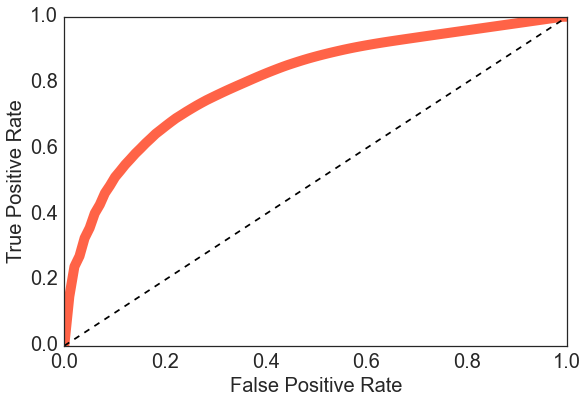

In [61]:
fig, ax = plt.subplots()

# Train, test, predict
for train_index, test_index in skf:
        # Divide the labeled set into train and test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Fit and transform the train set features
        X_train = imp.fit_transform(X_train)
        # Transform the test set features
        X_test = imp.transform(X_test)
        # Select a random forest classifier
        clf_cv = RF(class_weight = 'auto')
        # Train the classifier
        clf_cv.fit(X_train,y_train)
        # Predict on the test set
        y_pred = clf_cv.predict(X_test)
        # Get probabilities
        y_prob = clf_cv.predict_proba(X_test)
        # Get true positive rate and false positive rates for the ROC curve
        rf_fpr, rf_tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
        # Calculate the AUC
        rf_roc_auc = auc(rf_fpr, rf_tpr)
        auc_list.append(rf_roc_auc)
        # Calculate mean true positive rate
        mean_tpr += interp(mean_fpr, rf_fpr, rf_tpr)
        mean_tpr[0] = 0.0
        # Plot the ROC
#         ax.plot(rf_fpr, rf_tpr, alpha=0.1, color='MediumSlateBlue')
        # Record accuracy
        accuracy_list.append(np.mean(y_test == y_pred))
        # Transform the unlabeled dataset
        X_holdout = imp.transform(X_holdout)
        # Predict on the unlabeled set
        y_holdout = clf_cv.predict(X_holdout)
        # Get probabilities
        y_holdout_prob = clf_cv.predict_proba(X_holdout)
        probabilities.append(y_holdout_prob[:, 1])
        importances.append(clf_cv.feature_importances_)

# Plot the average ROC
mean_tpr /= iterations
mean_tpr[-1] = 1.0
ax.plot(mean_fpr, mean_tpr, c = 'Tomato', linewidth = 10.)

# Plot settings and labels
ax.plot([0, 1], [0, 1], 'k--')    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.tight_layout()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
ax.legend(fontsize = 20, loc = 'lower left')

print "Average accuracy: ", round(sum(accuracy_list)/float(len(accuracy_list)), 2)
print "Average AUC: ", round(sum(auc_list)/float(len(auc_list)), 2) 

## Plot feature importances

In [62]:
# Pivot the importance table
pivot_importances = dict()
for x in importances:
    for i, item in enumerate(x):
        if i in pivot_importances:
            pivot_importances[i].append(item)
        else:
            pivot_importances[i] = []
            pivot_importances[i].append(item) 

In [63]:
# For each feature, average importance measures that resulted from the 500 iterations of RF
avg_importances= {k:np.mean(v) for k,v in pivot_importances.items()}
# In the same way, calculate SD
std_importances = {k:np.std(v) for k,v in pivot_importances.items()}

In [64]:
# The order of features shoud be the same as in 'features' and 'features_holdout'
features_ord =[
        'number_of_chats',
        'nr_of_certificates',
        'sentiment',
        'avg_chat_length',
        'std_chat_length',
        'fraction_of_low_t_ratings',
        'fraction_of_low_c_ratings',
        'fraction_of_returning_students',
        'tutor_bayes_rating',
        'conn_bayes_rating',
        'std_tutor_rating',
        'std_connection_rating'
        ]

In [65]:
# Change keys from 0,1,2... to feature1, feature2, feature3... from the list above
for k, (k2,v2) in zip(features_ord, avg_importances.items()):
    avg_importances[k] = avg_importances.pop(k2)
for k, (k2,v2) in zip(features_ord, std_importances.items()):
    std_importances[k] = std_importances.pop(k2)

In [66]:
# Convert to pandas dataframes
avg_import_df = pd.DataFrame(avg_importances.items(), columns=['feature', 'avg_importance'])
std_import_df = pd.DataFrame(std_importances.items(), columns=['feature', 'std_importance'])

In [67]:
# Combine the two dataframes and sort by average importance (high to low)
importance_df = pd.merge(avg_import_df, std_import_df, left_on='feature', right_on='feature').sort('avg_importance', ascending = False)

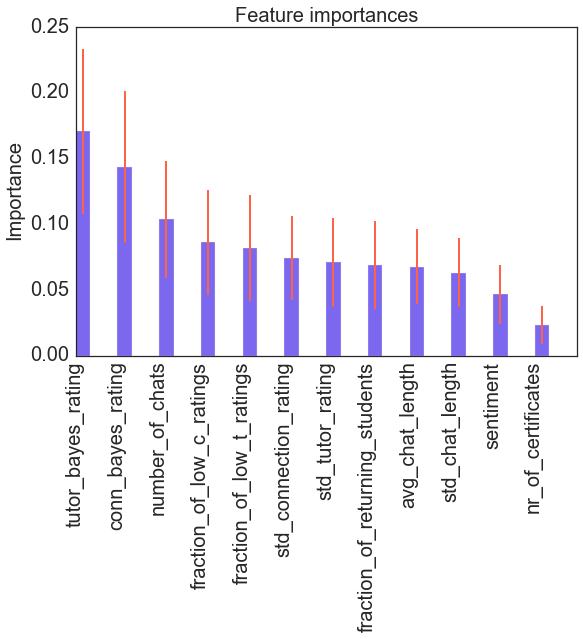

In [68]:
# Plot
ax_labels = importance_df['feature'].tolist()
N = len(avg_import_df)          # number of data entries
ind = np.arange(N)              # the x locations for the groups
width = 0.35                    #  bar width
fig, ax = plt.subplots()
ax.bar(ind, importance_df.avg_importance,        # plot importance of each feature
        width,                                   # bar width
        color='MediumSlateBlue',                 # bar colour
        yerr=importance_df.std_importance,       # data for error bars
        error_kw={'ecolor':'Tomato',             # error-bars colour
                  'linewidth':2}) 


ax.set_ylabel('Importance')
ax.set_title('Feature importances')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
ax.legend(fontsize = 20, loc = 'lower left')
ax.set_xticks(np.arange(12))
ax.set_xticklabels(ax_labels, rotation ='vertical')

## Average probabilities for the unlabeled set

In [69]:
# Pivot the probabilities list, put into a dictionary where the total number of keys 
# corresponds to the total number of tutors in the unlabeled dataset (the order is preserved)
pivot_probas = dict()
for x in probabilities:
    for i, item in enumerate(x):
        if i in pivot_probas:
            pivot_probas[i].append(item)
        else:
            pivot_probas[i] = []
            pivot_probas[i].append(item)    

In [70]:
# In the hold_out_predictions dict, include the probabilities as values
for (k,v), (k2,v2) in zip(hold_out_predictions.items(), pivot_probas.items()):
    hold_out_predictions[k] = v2

In [71]:
# Calculate averages and SD
avg_probabilities = {k:np.mean(v) for k,v in hold_out_predictions.items()}
std_probabilities = {k:np.std(v) for k,v in hold_out_predictions.items()}

In [72]:
# Convert to a pandas dataframe
avg_proba_df = pd.DataFrame(avg_probabilities.items(), columns=['tutorname', 'avg_prob'])
std_proba_df = pd.DataFrame(std_probabilities.items(), columns=['tutorname', 'std_prob'])

In [73]:
# Merge the two dataframes, sort by probability (high to low)
probabilities_df = pd.merge(avg_proba_df, std_proba_df, left_on='tutorname', right_on='tutorname').sort('avg_prob', ascending = False)

In [74]:
# Show top 15
# Note: high probability == the tutor is likely bad
# probabilities_df.head(15)

In [75]:
# Sample data for plotting
data_to_plot = probabilities_df[::redacted]

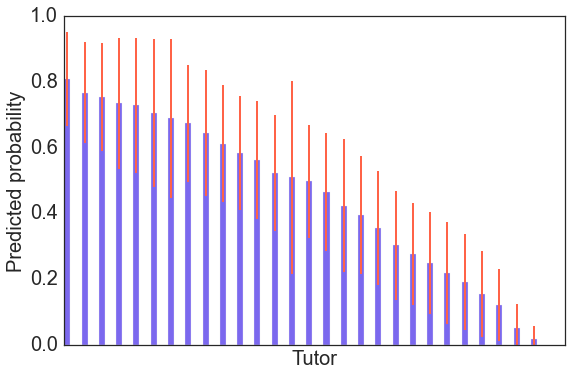

In [76]:
# Plot
N = len(data_to_plot)           # number of data entries
ind = np.arange(N)              # the x locations for the groups
width = 0.35 #  bar width
fig, ax = plt.subplots()
ax.bar(ind, data_to_plot.avg_prob,      # data
        width,                          # bar width
        color='MediumSlateBlue',        # bar colour
        yerr=data_to_plot.std_prob,     # data for error bars
        error_kw={'ecolor':'Tomato',    # error-bars colour
                  'linewidth':2}) 

ax.set_ylabel('Predicted probability')
ax.set_xlim([1,30])
ax.set_ylim([0,1])
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
ax.legend(fontsize = 20, loc = 'lower left')
ax.axes.get_xaxis().set_ticks([])
ax.set_xlabel('Tutor')